In [0]:
## Set up Google drive
from google.colab import drive
drive.mount('/content/drive')

## Set up the environment
!wget -O prepare_corpus.py https://raw.githubusercontent.com/tianyizz/project-reddit_watson/master/prepare_corpus.py
!wget -O urlmarker.py https://raw.githubusercontent.com/tianyizz/project-reddit_watson/master/urlmarker.py
!pip install watson_developer_cloud

import nltk
nltk.download("stopwords")
import json
from prepare_corpus import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
import watson_developer_cloud.natural_language_understanding_v1 as ai
import logging
logging.basicConfig(filename='error.log', level=logging.ERROR)  # This defines the name of the error log file
import types
import numpy as np
from botocore.client import Config
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import time

def __iter__(self): return 0

!pip install --upgrade "ibm-watson==3.4.2"
from ibm_watson import NaturalLanguageUnderstandingV1 as NLU #<-- import NLU

#CHANGE THE PATH TO YOUR CREDENTIALS FILE LOCATION
with open('drive/My Drive/Documents/SCHOOL/Watson CI/nlu_super_credentials.json') as f:
    creds_dict = json.load(f)
nlu = NLU(
    version='2019-07-12',
    iam_apikey=creds_dict["apikey"],
    url=creds_dict["url"]
)
from ibm_watson.natural_language_understanding_v1 import Features, EmotionOptions, CategoriesOptions, SentimentOptions
features=Features(
    sentiment=SentimentOptions(),
    emotion=EmotionOptions()
)



# Load the data from a .csv file

In [0]:
# CHANGE THE PATH TO YOUR DATA
baseFilePath = "/content/drive/My Drive/Documents/SCHOOL/Watson CI/Watson CI Parks Project"
dataFilePath = baseFilePath + "/Jacob Data/twitter_scraper_data_full_cleaned.csv"  #Got tired of the crazy long file path

# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(dataFilePath, "__iter__"): dataFilePath.__iter__ = types.MethodType( __iter__, dataFilePath )

df_data_1 = pd.read_csv(dataFilePath)
df_data_1.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,2,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,has media,hashtags,ID,img_urls,is_replied,is_reply_to,likes,links,parent_tweet_id,replies,reply_to_user,retweets,screen_name,text_notclean,timestamp,tweet_url,user id,username,video_url,CONTENT
0,False,['joshuatree'],1.06e+18,[],False,False,0,[],NaN,0.0,[],0.0,flipcars4profit,"#joshuatree @ Joshua Tree, California",10/27/2018 23:59,/flipcars4profit/status/1056334566879825920,4.815407e+08,Auto Dealers Mastermind,NaN,"#joshuatree @ Joshua Tree, California"
1,False,[],1.06e+18,[],False,False,0,['https://www.instagram.com/p/BpdKtNagxxI/?utm...,NaN,0.0,[],0.0,BrentWalls39,On this cold rainy Saturday thinking back to L...,10/27/2018 23:55,/BrentWalls39/status/1056333484011282432,7.726719e+08,Brent Walls,NaN,On this cold rainy Saturday thinking back to L...
2,False,[],1.06e+18,[],False,False,0,['https://twitter.com/space_books/status/10540...,NaN,0.0,[],0.0,bohemophiliac,TONIGHT! The debut of new @JailWeddings female...,10/27/2018 23:53,/bohemophiliac/status/1056333174748266496,9.950000e+17,Gabriel Hart,NaN,TONIGHT! The debut of new @JailWeddings female...
3,False,[],1.06e+18,[],True,True,1,[],1.060000e+18,1.0,"[{'screen_name': 'obiwankainobi', 'user_id': '...",0.0,wheatus,"Well, you never know. There were all manner of...",10/27/2018 23:41,/wheatus/status/1056330018840866822,1.747408e+07,wheatus,NaN,"Well, you never know. There were all manner of..."
4,False,[],1.06e+18,[],False,False,0,['https://www.swarmapp.com/c/jQG0xbViC1S'],NaN,0.0,[],0.0,sheckie420,"I'm at Joshua Tree Saloon in Twentynine Palms,...",10/27/2018 23:36,/sheckie420/status/1056328908893810688,7.537414e+07,John Sheckells,NaN,"I'm at Joshua Tree Saloon in Twentynine Palms,..."


# Use Watson NLU

### Define functions to make NLU call and process results

In [0]:
## NOTE - Currently the code is set up to use the columns "ID" and "CONTENT" of the tweet, with ID being the unique ID of the tweet and Content being the text of it
# This is what TwitterScraper calls the columns by default, so if you change it like making a "CleanedContent" column you'll need to change that here.  
# I recommend changing the column name in the csv file to "CONTENT" (instead of changing the code) because many of the functions use CONTENT hardcoded.  

# get response from NLU
def get_response(x):
    try:
        resp = nlu.analyze(text=x.CONTENT,
                                   features=ai.Features(
                                       sentiment=ai.SentimentOptions(),   # Get sentiment from the tweet (1 token)
                                       emotion=ai.EmotionOptions())       # Get the 5 emotion responses from the tweet (1 token)
                                   ).get_result()
    except Exception as e:
        resp = None
        print("Something went wrong.... Error: ", e)
        logging.error(e)  # This should log the error messages to an error.log file

    return resp

# prepare the response for entry into a dataframe
# Shouldn't have to change these if you're using both sentiment and emotion
def condition_response(resp):
    if resp is None:        
        cr = dict(nlu_status = "fail",
                emotion_anger = None,
                emotion_disgust = None,
                emotion_fear = None,
                emotion_joy = None,
                emotion_sadness = None,
                sentiment_label = None,
                sentiment_score = None,
                language = None,
                n_char = None)
    else:
        emotions = None if resp.get('emotion') is None else resp['emotion']['document']['emotion']
        sentiments = None if resp.get('sentiment') is None else resp['sentiment']['document']
        
        cr = dict(nlu_status = "pass",
                emotion_anger =  None if emotions is None else emotions['anger'],
                emotion_disgust = None if emotions is None else emotions['disgust'],
                emotion_fear = None if emotions is None else emotions['fear'],
                emotion_joy = None if emotions is None else emotions['joy'],
                emotion_sadness = None if emotions is None else emotions['sadness'],
                sentiment_label = None if sentiments is None else sentiments['label'],
                sentiment_score = None if sentiments is None else sentiments['score'],
                language = resp.get('language'),
                n_char = None if resp.get('usage') is None else resp['usage']['text_characters'])
        
    return cr

# process an individual row
# Change these if you want more/less extra stuff with the tweet
def process_row(x):
    rowIndex = x.name
    
    cr = condition_response(get_response(x))
    cr['ID'] = x['ID']
    cr['CONTENT'] = x['CONTENT']
    cr['timestamp'] = x['timestamp']
    cr['tweet_url'] = x['tweet_url']
    cr['username'] = x['username']
    cr['links'] = x['links']

    
    return cr

In [0]:
# Multi thread it
# define a function to do this nicely:
def get_results_multi_thread(df, nthread=20):  #30 max, 20 to be safe, 40 to be reckless
    
    # get an iterable for the rows of the dataframe
    rows = df.iterrows()
    nrows = df.shape[0]

    # wrapper function to handle extra index in iterable
    def process_row_no_idx(row):
        return process_row(row[1])
    
    # send rows to Watson NLU asynchronously
    with ThreadPoolExecutor(max_workers=nthread) as executor:
        # list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        futures = executor.map(process_row_no_idx, rows)

    # turn above iterator into list of results
    list_results = []
    for r in futures:
        list_results.append(r)

    # turn the list into a dataframe
    df_results = pd.DataFrame(list_results, columns=['CONTENT','ID', 'timestamp','tweet_url','username','links',
                                                       'nlu_status', 
                                                       'language',
                                                       'n_char', 
                                                       'sentiment_label', 
                                                       'sentiment_score', 
                                                       'emotion_anger', 
                                                       'emotion_disgust', 
                                                       'emotion_fear', 
                                                       'emotion_joy', 
                                                       'emotion_sadness'])
    
    # return the results
    return df_results

In [0]:
#Test it with just 20 rows

get_results_multi_thread(df_data_1.sample(20), nthread=20)

In [0]:
#THIS RUNS THE FULL THING BE CAREFUL 

num_splits = 100  #Number of csv files to output along the way, so that theoretically 
# if your runtime disconnects or something you can start the testing at whatever point it failed instead of needing to rerun the whole thing

df_split = np.array_split(df_data_1, num_splits)

split_idx = 0
loop_times = []
cos_res = []
analysis_response = []
for d in df_split:
    start_time = time.time()
    # progress
    print("Processing %i rows for split %i of %i"  % (d.shape[0], split_idx+1, num_splits))
    
    try:
        # get nlu results
        initialResponse = get_results_multi_thread(d, nthread=20)  #Hudson says 30 max not 40. Let's do 20 just to be safe

        # write this split to a file.  We don't really need to do this because it's also saving it in an array,
        # but it makes me feel better and it's fun seeing 100 csv files after it runs.  Necessary for starting part way through if it fails or disconnects. 
        filename = baseFilePath + '/Jacob Data/BatchAttempt5/split-'+str(split_idx).zfill(4) + '.csv'
        res_str = initialResponse.to_csv(filename)
        analysis_response.append(initialResponse)  #Add it to our full response


    except Exception as e:
        print("Failed to process split %i. Exception: %s" % (split_idx, e))
        print("Something failed while splitting the file")
    
    duration = time.time() - start_time
    loop_times.append(duration)
    avg_loop_time = sum(loop_times) / len(loop_times)
    est_remain = (num_splits - split_idx - 1)*avg_loop_time / 60
    
    # Show progress
    print(" --Iter. time: %0.1f seconds\n" % duration,
          "--Avg. iter. time: %0.1f seconds\n" % avg_loop_time,
          "--Est. time remaining: %0.1f minutes\n" % est_remain)
    
    split_idx+=1

#combine it all into one big file
fullResponse = pd.concat(analysis_response)
fullResponse.to_csv(baseFilePath + "/Jacob Data/BatchAttempt5/batchJT_response_array.csv")

Processing 577 rows for split 1 of 100
Something went wrong.... Error:  Error: unsupported text language: unknown, Code: 400 , X-global-transaction-id: 7d0d0c59c5b8d16237141eb746ee6473
Something went wrong.... Error:  Error: <HTML><HEAD>
<TITLE>Service Unavailable</TITLE>
</HEAD><BODY>
<H1>Service Unavailable - Zero size object</H1>
The server is temporarily unable to service your request.  Please try again
later.<P>
Reference&#32;&#35;15&#46;947f3517&#46;1574806512&#46;52a542e9
</BODY></HTML>
, Code: 503
Something went wrong.... Error:  Error: unsupported text language: unknown, Code: 400 , X-global-transaction-id: 303116f80dda7575e2380ab9a301a1c9
Something went wrong.... Error:  Error: unsupported text language: unknown, Code: 400 , X-global-transaction-id: 3c4179ab1bd66d5b9b8ddb4fc6d814dc
Something went wrong.... Error:  Error: unsupported text language: unknown, Code: 400 , X-global-transaction-id: 154a67fe983de1e62cea4461f024f4a9
Something went wrong.... Error:  Error: unsupported

In [0]:
#SKIP THIS PART IF YOU DIDN'T LET THE RUNTIME EXPIRE

#Load from the csv file on the off chance that you left and the runtime expired

fullResponse = pd.read_csv(baseFilePath + "/Jacob Data/BatchAttempt5/batchJT_response_array.csv")


Visualization and Results Analysis


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.0, 22880.0)

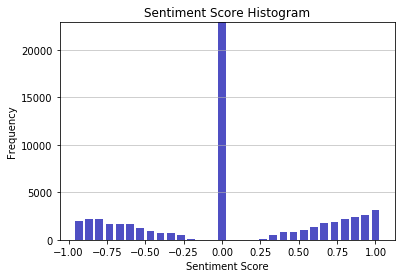

In [0]:
## NOTE - The below charts are really just for fun and confirming it got results correctly. 
#  You should really go over to the file that runs some R code for data analysis on it.  
# Link here:  <tbd> 

#Sentiment Score histogram
n, bins, patches = plt.hist(x=fullResponse.sentiment_score, bins=30, color='#0504aa', alpha=0.7, rwidth=0.75, align='right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Score Histogram')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)  # Set a clean upper y-axis limit.



/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.0, 44650.0)

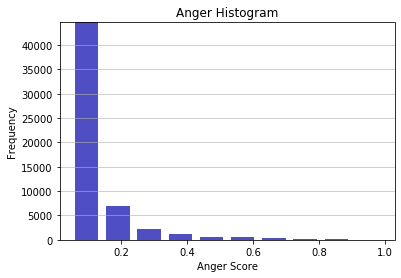

In [0]:
#Anger
#couldn't figure out how to not overwrite the previous chart so just made them into different sections
n, bins, patches = plt.hist(x=fullResponse.emotion_anger, bins=10, color='#0504aa', alpha=0.7, rwidth=0.75, align='right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Anger Score')
plt.ylabel('Frequency')
plt.title('Anger Histogram')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)  # Set a clean upper y-axis limit.

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.0, 9370.0)

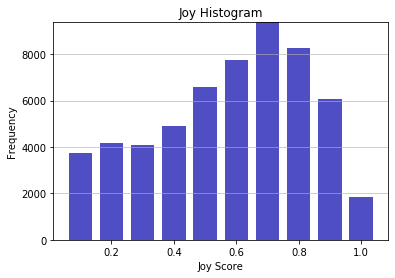

In [0]:
#Joy
n, bins, patches = plt.hist(x=fullResponse.emotion_joy, bins=10, color='#0504aa', alpha=0.7, rwidth=0.75, align='right')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Joy Score')
plt.ylabel('Frequency')
plt.title('Joy Histogram')
maxfreq = n.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)  # Set a clean upper y-axis limit.